In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#check version pandas

# Seaborn is a cool library to use whenever starting data exploration


import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 10
plt.rc("font", size=23)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

# Data exploration
## Table Of Content:
* [**Rapid look at the data**](#first-bullet)


* [**Features selection**](#second-bullet)


* [**A little bit of data wrangling**](#third-bullet)
     * [Replacing weird types](#third-first-bullet)
     * [Counting missing data](#third-second-bullet)
     * [What to do with missing data?](#third-third-bullet)
     * [Making sure columns are the right type](#third-fourth-bullet)
     * [ One hot encoding of categorical data](#third-fifth-bullet)
     
     
* [**Dimensionality reduction/Embedding**](#fourth-bullet)
    * [PCA](#PCA-bullet)
    * [Multidimensional scaling](#MDS-bullet)
    * [t-SNE](#tsne-bullet)
     

* [**Clustering methods**](#fifth-bullet)
    * [K-means](#Kmeans-bullet)
    * [Hierarchichal clustering](#HC-bullet)
    * [DBSCAN](#DBSCAN-bullet)
    
    
* [**Evaluating clustering realtion to labels : ARI**](#sixth-bullet)


* [**Exo**](#exo-bullet)

For this intoduction we will be using the iris dataset. It is a dataset that describes our target `species` thanks to 4 features : `sepal_length`, `sepal_width`, `petal_length`, and `petal_width`. It is composed of 150 points.

There are 3 species of iris (*setosa*, *versicolor*, *virginica*). The goal here would be to understand how good our features are at classifying those 3 species. It is an exploratory step in understanding our data, before going through actual supervized modeling that will come in the next segment of the class.

# Rapid look at the data <a class="anchor" id="first-bullet"></a>

In [3]:
df=sns.load_dataset("iris")
# Here we use the data loader from seaborn but such data loaders also exist with scikit-learn and are more generally delt
#with the dataframe handler pandas
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Check how the classes are represented (maybe it is really imbalanced?).

Check also the type of data you have (numerical, categorical...?). 

We can first look at `pairplot` to see if some features are similar or independent from each other as well as how those features are good describers of our target.

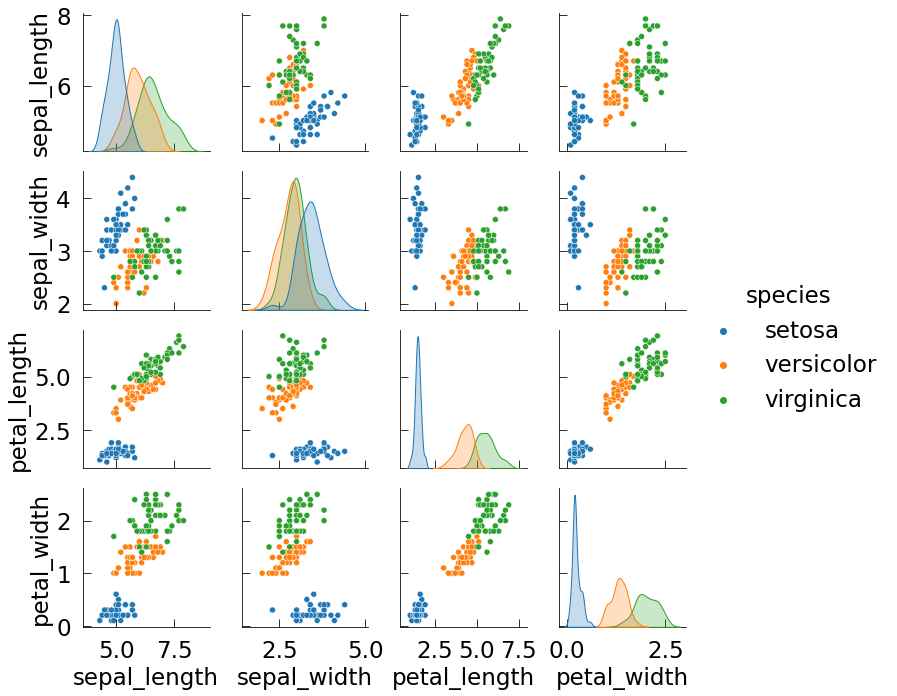

In [4]:
sns.pairplot(df,hue="species")
# Seaborn allows you to 'split' your data according to a chosen parameter hue. Here I chose to color split the data according
#to the target
#description diagonal

What do you get from the plots above?

Looking at the diagonal of these plots : petal features separate the species more efficiently than sepal features.

There is a very strong correlation between `petal_length` and `petal_width` : those two features are probably so similar that keeping them both could be redundant.

The least correlation visible seems to be between `sepal_width` and all the others.

By itself `sepal_width` is not good at differentiating species but associated with other features we can already see groups forming by species. And since they are very much non-colinear I would say that, in dimension two, `petal_length` and `sepal_width` are already a good pick for low dimensions models.

You can actually quantify the correlation between features by calling the `corr()` function in pandas.

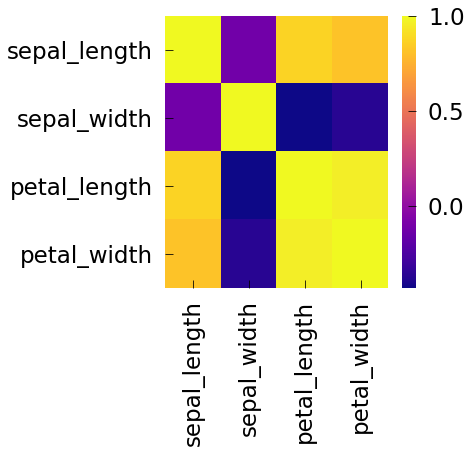

In [5]:
import pandas as pd
df_corr = pd.DataFrame(df.corr(),columns=list(df.columns)[:-1])
# pca.components_ : recovering the matrix that describes the principal component in the former feature basis
plt.figure(figsize=(5,5))
sns.heatmap(df_corr,cmap='plasma')
plt.yticks(np.arange(0+0.5,4+0.5,1),[v for v in df_corr.columns],rotation=0)
plt.show()

# Features selection <a class="anchor" id="second-bullet"></a>

One thing (among others) that you can do is to look for a **subset of features that seems to be important to describe the target class**. It's like the pairplots above but instead of just looking at it you choose the features you want to keep.

You can choose different metrics for 'how important to describe the class' a feature is. 
Many of those metrics utilize concepts that we haven't introduced yet, in contexts that we haven't seen yet, so I will introduce two metrics for classification that don't need too much of *a priori* knowledge. 

`Scikit-learn` lets you specify a threshold on the features are kept, either as:
* a direct number: `SelectKBest`.
* important features from a percentile of your top importance score: `SelectPercentile`.
* an error type: `SelectFpr` or `SelectFdr` (see course 2 logistic regression part).


`Scikit-learn` offers you different scores to calculate the importance of your features.

* **ANOVA-F** : F=$\frac{Var_{feature\_i}(Between\_class)}{Var_{feature\_i}(Within\_class)}$. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
**F** itself gives you how much a feature $i$ variance is different between classes, normalized by the intrinsic variance of that feature per class. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
So if **F** is big it means that the variation that you observe between classes is big compared to the variance of this feature : 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
it behaves differently for different classes so it it is a good feature to keep for the classification. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
To this **F** is associated a **p-value** that you would use for scoring.


* **Chi2** ($\chi^{2}$) test. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
You suppose in the null hypothesis that this feature $i$ is homogenously distributed among classes

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
and so you are expecting that its representation in different classes should be very similar to what you can calculate for the bulk data

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
 i.e. $\frac{\Sigma^{n\_points} feature_{i}}{n\_points}$.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
You then compare the actual distribution of this feature in different classes to your null model predictions. If this **sum of square differences**: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
$\Sigma^{n\_class}_{k}\frac{(expected\_form\_null\_hypothesis_{k}-observed_{k})^{2}}{observed}$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 
is big then the null hypothesis has to be rejected and this feature is significant for classifying. 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
The sum of these square quantities over the different classes asymptotically follows a $\chi^{2}$ 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
distribution and thus you have access to a **p-value for scoring**.


Another score would be to use the amount of [Mutual Information](https://en.wikipedia.org/wiki/Mutual_information) shared between a feature and our target. 

The way this mutual information is caclulated is out of the scope of this class as it is a bit technical.




Let's see how to use that on a practical example. The example itself is not very interesting because the iris dataset only contains 4 features. But at least it presents the code.

In [6]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

skb = SelectKBest(chi2, k=2)#creating the object SelectKBest and settling for 2 best features (k=2) in term of chi2 score
skb.fit(df[list(df.columns)[:-1]], df[list(df.columns)[-1]])#calculating the chi2 for each features

dico_pval={df.columns[i]:v for i,v in enumerate(skb.pvalues_)}
print("features Chi2 scores (p-values):")#all the features and the chi2 pvalues associated. use .pvalues_
for feature,pval in dico_pval.items() :
    print('\t',feature , ':' , pval )

X_new=skb.transform(df[list(df.columns)[:-1]])# keep only the k=2 best features according to the score

print("New data with only the k=2 best features kept :")
print(X_new[:5,]) #printing only the 5 first entries
print('...')

features Chi2 scores (p-values):
	 sepal_length : 0.004476514990225747
	 sepal_width : 0.1563959804316255
	 petal_length : 5.533972277193946e-26
	 petal_width : 2.758249653003403e-15
New data with only the k=2 best features kept :
[[1.4 0.2]
 [1.4 0.2]
 [1.3 0.2]
 [1.5 0.2]
 [1.4 0.2]]
...


# A little of data wrangling <a class="anchor" id="third-bullet"></a>

Let's play a little bit with some real world dataset which are as messy as they will come. This dataset is mainly used for predicting cars prices according to some cars characteristics. Thus it is usually used for regression, but don't worry about that. For now we are just going to explore some useful data wrangling concepts and no regression at all.

In [8]:
import pandas as pd
df = pd.read_csv('Automobile_data.csv')
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


### Replacing weird types <a class="anchor" id="third-first-bullet"></a>

In [9]:
# some missing entry are marked with "?", let's replace that with NaN
df.replace("?", np.nan, inplace = True)
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


### Counting missing data <a class="anchor" id="third-second-bullet"></a>

In [10]:
#small piece of code to check the number of missing values per columns (features), True is missing
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    nbMissing = sum( missing_data[column] ) 
    print(column.rjust(20) , '\t: missing ',nbMissing)    

#NB : the .rjust() is just here for aesthetic purposes

           symboling 	: missing  0
   normalized-losses 	: missing  41
                make 	: missing  0
           fuel-type 	: missing  0
          aspiration 	: missing  0
        num-of-doors 	: missing  2
          body-style 	: missing  0
        drive-wheels 	: missing  0
     engine-location 	: missing  0
          wheel-base 	: missing  0
              length 	: missing  0
               width 	: missing  0
              height 	: missing  0
         curb-weight 	: missing  0
         engine-type 	: missing  0
    num-of-cylinders 	: missing  0
         engine-size 	: missing  0
         fuel-system 	: missing  0
                bore 	: missing  4
              stroke 	: missing  4
   compression-ratio 	: missing  0
          horsepower 	: missing  2
            peak-rpm 	: missing  2
            city-mpg 	: missing  0
         highway-mpg 	: missing  0
               price 	: missing  4


### What to do with missing data? <a class="anchor" id="third-third-bullet"></a>

Replace your missing data by the mean of those features, or whatever you think is a good replacement (median, weighted average etc...)

In [11]:
# Replace your missing data by the mean of those features
columnMeanImputation = [ "normalized-losses" , 'bore' , 'stroke' , 'horsepower' , 'peak-rpm' ]

for colName in columnMeanImputation :
    avg = df[colName].astype("float").mean(axis=0)#calculating the mean following axis 0, so per columns
    df[colName].replace(np.nan, avg , inplace=True)#replacing missing value by the mean


# in some other cases it makes more sense to replace missing values by the most frequent entry (mode)
print("number of doors : ")
print(df['num-of-doors'].value_counts())
mode = df['num-of-doors'].value_counts().idxmax()

df["num-of-doors"].replace(np.nan, mode, inplace=True)




number of doors : 
four    114
two      89
Name: num-of-doors, dtype: int64


In [12]:
len(df)

205

In [13]:
#If you are interested in lines rather than columns you can drop lines (index) for which a certain feature is NAN.
Nbefore = len(df)
df.dropna(subset=["price"], axis=0, inplace=True)# removing lines where the price is NA

df.reset_index(drop=True, inplace=True) # update the index to account for the dropping
Nafter = len(df)

print('dropped',Nbefore-Nafter,'entries')

dropped 4 entries


In [14]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,122,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,122,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


For more imputation technics : [Scikit-learn imputation](https://scikit-learn.org/stable/modules/impute.html) . The litterature on imputing missing data is huge (much bigger than what is implemented on scikit learn). I recommend caution when imputing data. It is not the aim of that course, but be sure that the field of imputation could be a course of its own.

### Making sure columns are the right type <a class="anchor" id="third-fourth-bullet"></a>

In [15]:
df.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

As you can see here some features (like horsepower) which are supposed to be `int` are categorized as `object`... 

This will be a problem. Make sure your features are of the right type.

In [16]:
df["horsepower"]=df["horsepower"].astype(int, copy=True)#changing type object to type int

In [17]:
df[["bore", "stroke"]] = df[["bore", "stroke"]].astype("float") # you can convert multiple columns at once
df[["normalized-losses"]] = df[["normalized-losses"]].astype("int")
df[["price"]] = df[["price"]].astype("float")
df[["peak-rpm"]] = df[["peak-rpm"]].astype("float")

In [18]:
df.dtypes

symboling              int64
normalized-losses      int64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower             int64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

### One hot encoding (that's the name of the method....) of categorical data <a class="anchor" id="third-fifth-bullet"></a>

In [19]:
print("fuel type : ")
print(df['fuel-type'].value_counts())


fuel type : 
gas       181
diesel     20
Name: fuel-type, dtype: int64


If you look at `fuel_type`, its type is `object` and more particularly a category : either diesel or gas. And some models work only with numbers not categories. So we can transform them into numbers

In [20]:
dummy_variable_1 = pd.get_dummies(df["fuel-type"])#get_dummies allows you to transform a categorical type to a numerical type
dummy_variable_1.head()

,diesel,gas
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [21]:

df = pd.concat([df, dummy_variable_1], axis=1)#add your newly made numerical type

df.drop("fuel-type", axis = 1, inplace=True)#don't forget to drop your former column fuel_type

In [22]:
df.head()

,symboling,normalized-losses,make,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,...,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,diesel,gas
0,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,168.8,...,3.47,2.68,9.0,111,5000.0,21,27,13495.0,0,1
1,3,122,alfa-romero,std,two,convertible,rwd,front,88.6,168.8,...,3.47,2.68,9.0,111,5000.0,21,27,16500.0,0,1
2,1,122,alfa-romero,std,two,hatchback,rwd,front,94.5,171.2,...,2.68,3.47,9.0,154,5000.0,19,26,16500.0,0,1
3,2,164,audi,std,four,sedan,fwd,front,99.8,176.6,...,3.19,3.40,10.0,102,5500.0,24,30,13950.0,0,1
4,2,164,audi,std,four,sedan,4wd,front,99.4,176.6,...,3.19,3.40,8.0,115,5500.0,18,22,17450.0,0,1


# Enough with data processing let's start some real science!!!

## Dimensionality reduction <a class="anchor" id="fourth-bullet"></a>

Maybe you don't need all those features to describe your data : maybe some features are redondant, or a new feature composed of a combination of several features is a better descriptor of your data. 

With dimensionnality reduction we aim at *'simplifying'* how your data is represented by transforming your features.

### PCA (Principal Component Analysis) <a class="anchor" id="PCA-bullet"></a>

PCA is a dimensionality reduction method based on the diagonalization of the covariance matrix (sum of the  squared deviation from the means).

#### For a little bit of mathematics:


Basically you are looking for the matrix of eigenvalues $\pmb{\Lambda}$ and basis transfert (eigenvectors) $\pmb{W}$, that satisfies the following relation:

$\pmb{X}^T\pmb{X}=\pmb{W}\pmb{\Lambda}\pmb{W}^T$

Where in this case $\pmb{X}$ has been centered around the mean of each features, so that $\pmb{Q}=\pmb{X}^T\pmb{X}$ is the covariance matrix of your multidimensional data.

Note: all the algorithms that acutally perfom PCA use Singular Value Decomposition (SVD) which is another way to end up diagonalizing the covariance matrix. Look into it if you are interested it is pretty neat.

The theory of positive semi definite matrix, that describes the matrix $\pmb{X}^T\pmb{X}$ tells us that the vectors stored in the matrix $\pmb{W}$ are actually the direction of greatest variances of our data set. We can even rank the importance of those direction by ranking the eigenvalues $\lambda_p$ associated to the vector $\pmb{W}_p$.


#### Back to hand waving:

The output of such a process is a set of eigenvectors (which are a linear combination of your former features) and how much those new vectors are important (eigenvalues) to explain the variance in your data. 

The eigenvector associated with the first eigenvalue describes the direction along which the covariance is the highest, meaning that it would be along that direction that the points are more spread. 
The second egeinvector do the same but as it forms an orthogonal basis in the space of covariance, the second eigenvector can only give information about some deviation to the mean not explained by the first eigenvector. 
And so on and so forth until there is no more eigenvector (and standard deviation to explain).

In general I recommend working with the **correlation matrix** instead of the covariance matrix. Doing so you make sure that **deviations to different means are scaled the same way**. You don't want to pick your PCA1 along feature $j$ just because it has a bigger scale but not a real bigger spread.

Imagine you have two features that are a related by a linear function : how do the mean and the variance compare?

Below an example of non scaled PCA with dimensions (features) having different scales



### Unscaled toy data for importance of rescaling


In [54]:
# creating some toy data : just two classes 
# that are explained by different scales along x and y and different means.
# (you don't need two for what I am trying to prove but for consistency I decided to use 2)

X1=np.zeros((50,2),dtype='f')
X2=np.zeros((50,2),dtype='f')
for i in range(50):
    X1[i][0]=np.random.randn()*5+10 #(one axis has a scale of 5)
    X1[i][1]=np.random.randn()*25+10 #(one axis has a scale of 25)
    X2[i][0]=np.random.randn()*5+-2
    X2[i][1]=np.random.randn()*25+2
X=np.vstack(np.array([X1,X2]))
np.shape(X)

(100, 2)

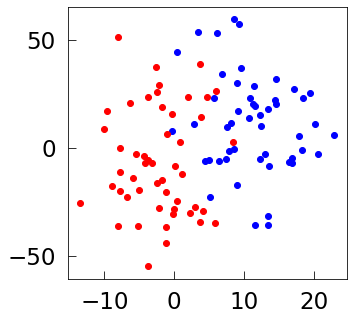

In [55]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
plt.plot(X[:50,0],X[:50,1],'bo')
plt.plot(X[50:,0],X[50:,1],'ro')
plt.show()

If you want to separate the red points from the blue points your intuition would tell you to draw a vertical line somewehere around $x=4$. 

Can the PCA help us do better than that? 

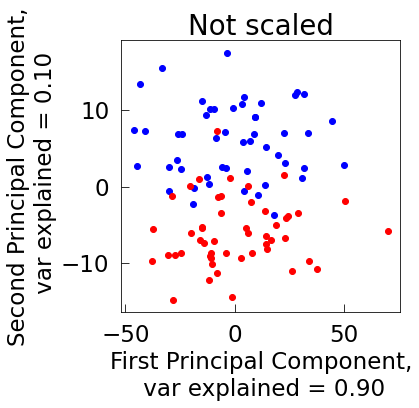

In [25]:
from sklearn.decomposition import PCA

pca = PCA()#create a PCA object

pca.fit(X)#calculate the eigenvalues and eigenvectors according to data

x_pca = pca.transform(X)# Calculate the new points coordinates according to the previously found eigenvectors.
var_explained=pca.explained_variance_ratio_
plt.figure(figsize=(5,5))
plt.scatter(x_pca[:50,0],x_pca[:50,1],color='b')
plt.scatter(x_pca[50:,0],x_pca[50:,1],color='r')
plt.title('Not scaled')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))

plt.show()

If you don't rescale you might have the impression that 91 % (see `First principal component, var explained=0.91`) of your variance comes from the first component and so that your data is almost one dimensional... 
In fact by construction you know that it is not true and the only thing that you are measuring is the difference of scales in the data.

Even worse : you could have an intuition of where to cut to split qualitatively your data but now your PCA is telling that the inner organization of the data doesn't follow your intuition (your intuition tells you to do it along the second axis, but the PCA tells you that's not much of how your data are organized...).

However, when you rescale you realize that the two dimensions are actually equivalent (see below), and your intuitive cuting follows a perfect linear combination of those two equivalent dimensions!

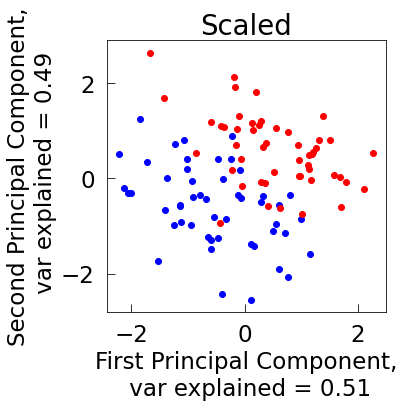

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #define the scaler object
scaler.fit(X) 
scaled_data = scaler.transform(X)
pca = PCA()#create a PCA object

pca.fit(scaled_data)#calculate the eigenvalues and eigenvectors according to rescaled data

x_pca = pca.transform(scaled_data)# Calculate the new points coordinate according to the previously found eigenvectors.
var_explained=pca.explained_variance_ratio_
plt.figure(figsize=(5,5))
plt.scatter(x_pca[:50,0],x_pca[:50,1],color='b')
plt.scatter(x_pca[50:,0],x_pca[50:,1],color='r')
plt.title('Scaled')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))

plt.show()

`sklearn.preprocessing.Normalizer`: you can choose your norm eitheir l1, l2 or max :

 L1 normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{\sum_{i}|X_{i,j}|} $$
 L2 normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{\sqrt{\sum_{i}X_{i,j}^2}} $$
 max normalization for covariables $X_{:,j}$$$ \frac{X_{:,j}}{max_i(X_{i,j})} $$


You could also use the z variable kind of scaling `sklearn.preprocessing.StandardScaler`: 

$$ \frac{X_{:,j}-\bar{X_{:,j}}}{\sigma_j} $$


Or use a min max scaler `sklearn.preprocessing.MinMaxScaler`

Of course you should choose the scaling you use according to the statistic of your data. If the min and the max of your data are kind of outliers then a min max method is probably not the right choice. Those outliers will also influence greatly the l1 or l2 normalization.

In the above example I chose the the standard scaler that act like a z variable transform

Wether scaling needs to happen or not is a decision that should be driven by your knowledge of the data (is there an actual difference of scale between those features or what I am seeing is part of the signal that I would like to recover). There is no obligation to do so, the example here is just to show you that it can be usefull.

### PCA on the Iris dataset

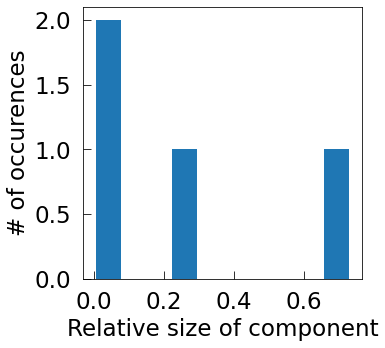

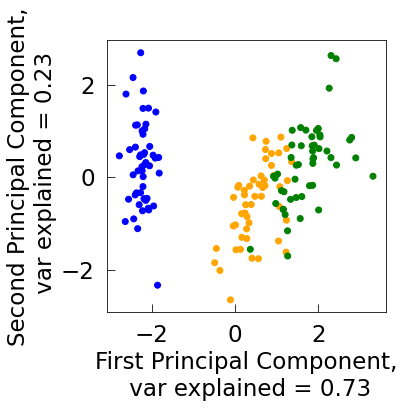

In [27]:
df=sns.load_dataset("iris")
from sklearn.preprocessing import StandardScaler
# standard scaler centered around the empirical mean (what you want to calculate for covariance matrix) and rescaled by dividing by the empirical
# standard deviation (what you want for correlation matrix and good scaling). It is a Z random variable if you want.

scaler = StandardScaler() #define the object
scaler.fit(df[list(df.columns)[:-1]]) # get the mean and sd form our data : in our dataframe features goes up to the last 
#column. The last column being the target. So we take all the columns except the last one

scaled_data = scaler.transform(df[list(df.columns)[:-1]])# actually transform the data by rencentering and recalling it.

from sklearn.decomposition import PCA

pca = PCA()#create a PCA object

pca.fit(scaled_data)#calculate the eigenvalues and eigenvectors according to rescaled data

x_pca = pca.transform(scaled_data)# Calculate the new points coordinate according to the previously found eigenvectors.

color_dict={'setosa':'blue', 'versicolor':'orange', 'virginica': 'green'}
color_list=[color_dict[df['species'][i]] for i in range(len(df['species']))]

var_explained=pca.explained_variance_ratio_#get the explained variance ratio from our fitted pca object
#plot the distribution of eignevalues (actually Singular values):
plt.figure(figsize=(5,5))
plt.hist(var_explained,10)
plt.ylabel('# of occurences')
plt.xlabel('Relative size of component')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))

plt.show()

It is always nice to check if the eigenvalues that we are considering are actually interesting by looking at the distribution of eigenvalues. Even if the variance explained is not great, if at least the eigenvalues that we chose are very much different from each other then they might be interesting.

Here, as our two principal components represent 96 % (you have two components : one component representing 73% of variance explained and the other 23%) of the total variance we can conclude that we found a good low dimensional representation of the data. We should try to work on that low representation of data instead of the 4 dimensional space!!!!

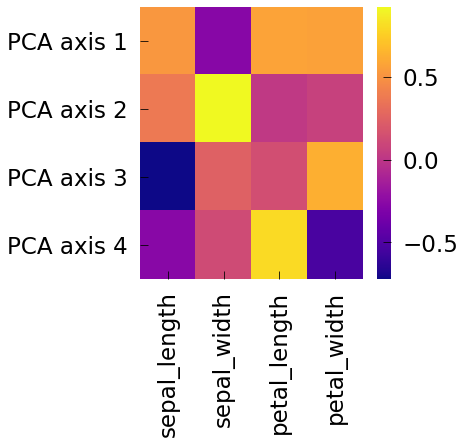

In [28]:
import pandas as pd
df_comp = pd.DataFrame(pca.components_,columns=list(df.columns)[:-1])
# pca.components_ : recovering the matrix that describe the principal component in the former feature basis. It gives you the 
# values of the coefficients in front of each features to build your PCA components.
plt.figure(figsize=(5,5))
sns.heatmap(df_comp,cmap='plasma')
plt.yticks(np.arange(0+0.5,4+0.5,1),['PCA axis '+str(i+1) for i in range(4)],rotation=0)
plt.show()

In [29]:
pca.components_

array([[ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654],
       [ 0.37741762,  0.92329566,  0.02449161,  0.06694199],
       [-0.71956635,  0.24438178,  0.14212637,  0.63427274],
       [-0.26128628,  0.12350962,  0.80144925, -0.52359713]])

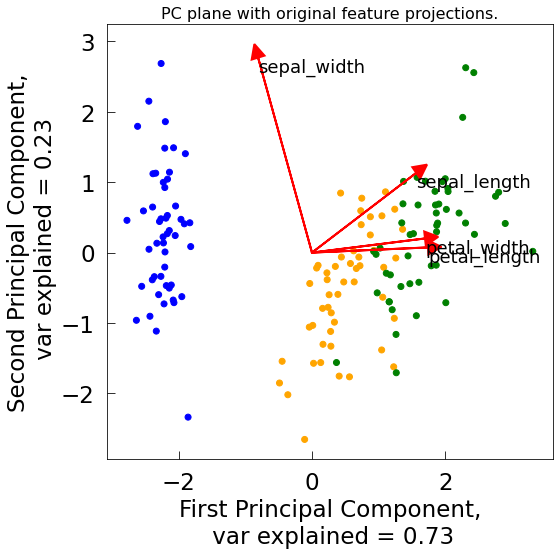

In [30]:
# add the original vector (features) to the PCA to visualize what those principale components mean 

fig, ax = plt.subplots(figsize = (8,8))
 
ax.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma')
    
feature_vectors = pca.components_.T
#Going from the feature base to the PCA base is easy : one is just the other transposed.

# we use scaling factors to make the arrows easier to see
arrow_size, text_pos = 3.0,3.0,

# projections of the original features
for i, v in enumerate(feature_vectors):
    ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1],head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(v[0]*text_pos, v[1]*text_pos, df.columns[i], color='black',ha='left', va='top', fontsize=18)

    
ax.set_title("PC plane with original feature projections.", fontsize=16)
    
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))
plt.show()

We can always go back to the feature space to understand to what our PCA axis correspond (not very practical when high dimensionality of features but I am sure you can work around that). Here the first axis is the petal-like feature (as we guessed before) and the second axis is almost entierely  the sepal width (also as we guessed). Notice how `sepal_length` is quite balanced combination of petal length/width and sepal width?

Let's check other methods of dimensionality reduction/representation that are a little bit more relaxed in terms of what they define as distance/similarities.

### MultiDimensional Scaling <a class="anchor" id="MDS-bullet"></a>

Multidimensional (MDS) scaling is a method that tries its best to **conserve distances** relationships between points in a starting high dimensional space and in a final reduced or equal space (*i.e.* it minimize a *stress function* which report the differences between distances calculated in the high dimensional space and Euclidian distances in the lower or equal dimensional space). 

Under some conditions (*i.e.* when the distances calculated in the high dimensional space are Euclidians) it is totally equivalent to PCA. The strength of this method is that it works with other distances or even no distance but just rankings: the algorithm will find the "*best*" set of coordinates to represent your points so that the euclidian distances in the final space ressemble the "*distances*" in the initial dimensional space.


#### For a little bit of mathematics:


The classical problem in multidimensional scaling is the following: 

Given the distances between points find the coordinate of the points. Imagine you are given flight times between cities in the U.K. : place the cities accordingly (and potentially redraw the map of U.K.). To do so Multidimensional Scaling is going to minimize a stress function defined as :

$Stress(\pmb{x_1},..,\pmb{x_n})=\sum_{i\neq j}^{n(n-1)}(d_{i,j}-||\pmb{x_i}-\pmb{x_j}||_{\{\mathcal{P}\}})^2$

Where $d_{i,j}$ is related ( for most of the cases let's just says that it is the distance) to the given distance between point i and j, and $||\pmb{x_i}-\pmb{x_j}||_{\{\mathcal{P}\}}$ the Euclidian distance between point i and j, given a certain euclidian space $\mathcal{P}$ of dimension p. $\mathcal{P}$ is the space where the projection occurs.

I will stop here for the mathematical description of this method as in the detail it can become confusing.  

The cool thing is that you can actually choose to match the distances in the initial space (whatever those types of distances are), to Euclidian distances in what ever dimension space and so proceed to a dimension reduction.

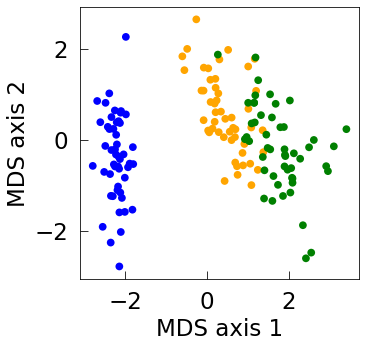

In [33]:
#MDS project data : here specificaly in 2D

from sklearn.metrics import euclidean_distances
from sklearn import manifold
plt.figure(figsize=(5,5))

similarities = euclidean_distances(scaled_data) #used the same rescaled data as PCA
#here I am using the euclidian distance calculator, MDS in that case if nothing more 
#than PCA. MDS becomes interesting when the distance you have been given
#at the beginning are not Euclidian... So this is a bit of a redondant
#example with the PCA one
mds = manifold.MDS(n_components=2, max_iter=3000, eps=1e-9, random_state=np.random.RandomState(seed=3),
                   dissimilarity="precomputed", n_jobs=1)#n_components to choose the dimension of the projected space
pos = mds.fit(similarities).embedding_#fit and transform the data in the reduced space

plt.scatter(pos[:, 0], pos[:, 1], color=color_list, s=60, lw=0, label='MDS')
plt.xlabel('MDS axis 1')
plt.ylabel('MDS axis 2')
plt.show()

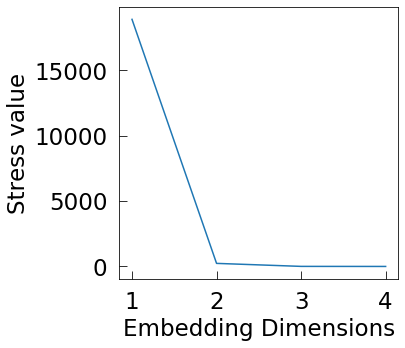

In [83]:
#Compute the stress function for different dimensions of embedding

similarities = euclidean_distances(scaled_data)
stress=[]
plt.figure(figsize=(5,5))
for i in range(1,5):
    mds = manifold.MDS(n_components=i, max_iter=3000, eps=1e-9, random_state=np.random.RandomState(seed=3),
                   dissimilarity="precomputed", n_jobs=1) #compute the stress values for MDS with different n_components values
    stress.append(mds.fit(similarities).stress_)

plt.plot(np.arange(1,5,1),stress)
#plt.yscale('log')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Stress value')
plt.show()

As you probably noticed, here unlike PCA, we had to actually chose from the beginning the dimensions of the low dimensional representation. 
With PCA you choose the number of dimensions necessary for your data representation by looking at the variance explained. 
Here you can not properly do that. 
What you can do instead is to **check how much adding a new dimension to explain your data improves your goal of matching distances**. 

Here for example, the stress value (the square difference between distances in the low dimensional space and distances in the high dimensional space) decreases sensibly between 1 and 2 dimensions, then less noticeably. 
Projecting in 2D seems to be a good compromise.

### t-SNE (t-distributed Stochastic Neighbor Embedding <a class="anchor" id="tsne-bullet"></a>

T-SNE is a dimensionality reduction algorithm that is becoming more and more popular. It is a non linear method as the euclidian distances used in the high dimensional space are quite non linearly transformed. 

#### For a little bit of mathematics:

Very quickly, what the algo is doing is to model the distances in the high dimensional space as drawn from a Gaussian distribution around each data points with a certain variance $\sigma^2$. Namely distance between points $\bf{x_i}$ and $\bf{x_j}$ is represented as : 

$p_{i|j}=\frac{exp(-||x_{i}-x_{j}||^2/(2\sigma_i^2))}{\sum_{k\neq_i}exp(-||x_{i}-x_{k}||^2/(2\sigma_i^2))}$

The same kind of representation is going to be used for the lower dimensional space, but this time with a t distribution instead of a Gaussian (this is related to the crowding problem and will allow better visual separability of the clusters in the low dimension space, but to what cost...):

$q_{i|j}=\frac{(1+||y_{i}-y_{j}||^2)^{-1}}{\sum_{k\neq_i}(1+||y_{i}-y_{k}||^2)^{-1}}$

Now we just need those distributions to be as closed as possible for a "good" representation. For that the algo is going to use and minimize the sum of the Kullback-Leibler divergences between $P_i$ and $Q_i$ :

$C=\sum_{i}KL(P_i||Q_i)=\sum_{i}\sum_{j}p_{i|j}log(\frac{p_{i|j}}{q_{i|j}})$

#### Back to just talking

t-SNE has an hyperparameter called `perplexity` which, roughly speaking, stands for a typical number of neighbors to consider : it is related to the $\sigma_i$ in the high dimension space.

Finally t-SNE doesn't conserve distances nor densities : it is trully a visualization technic and should not be used with other clustering technic that demand distances or density conservation between full and reduced space.

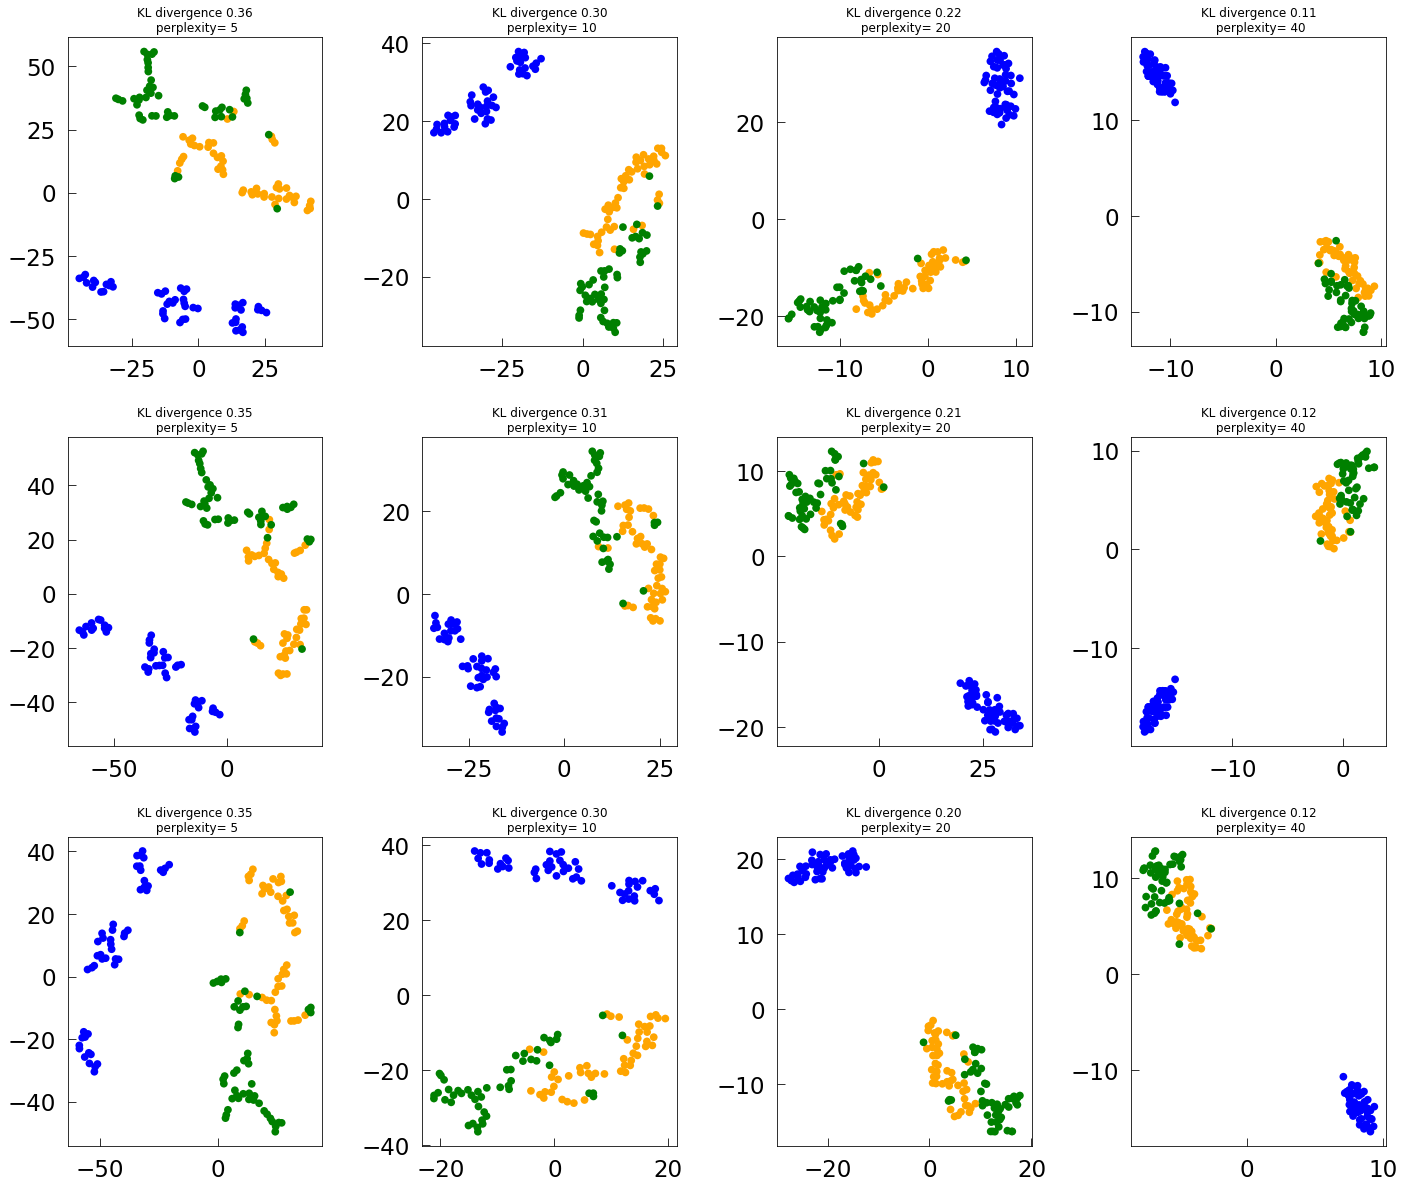

In [64]:
#creates many T-SNE of the same data but with different perplexity parameters and multiple times to see the influence
#of perplexity and randomness of the projection

from sklearn.manifold import TSNE

p=[5,10,20,40]#perplexity parameters to test
plt.subplots(figsize=(20,17))
for i in range(3):
    for j in range(len(p)):
        plt.subplot(3,4,4*i+j+1)
        tsne=TSNE(n_components=2,perplexity=p[j]).fit(scaled_data)#create the T-SNE object and fit the data

        X_embedded = tsne.embedding_#project the data to the new manifold using the fitted function found before
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color_list, s=60, lw=0)
        plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,p[j]),fontsize=12)
plt.tight_layout()
plt.show()


In this plot each row is a T-SNE representation made with a different perplexity parameter. Each column is the same T-SNE repeated 3 different times.

You can see that within the same column, even though the perplexity parameter is the same the representations are quite different : it is normal and '*kind of*' equivalent (it is totally ok to choose the representation with the smallest KL value in the set of models with the same perplexity). Remember that, **running multiple times the same t-SNE will give you different equivalent representations**.

You can also see that this perplexity parameter is really determining in the topology of the results you will get. It is your guess to pick a perplexity parameter that you believe is the best representation of the data. I highly encourage everybody to take a look at [this](https://distill.pub/2016/misread-tsne/)

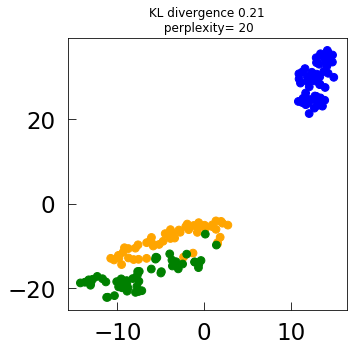

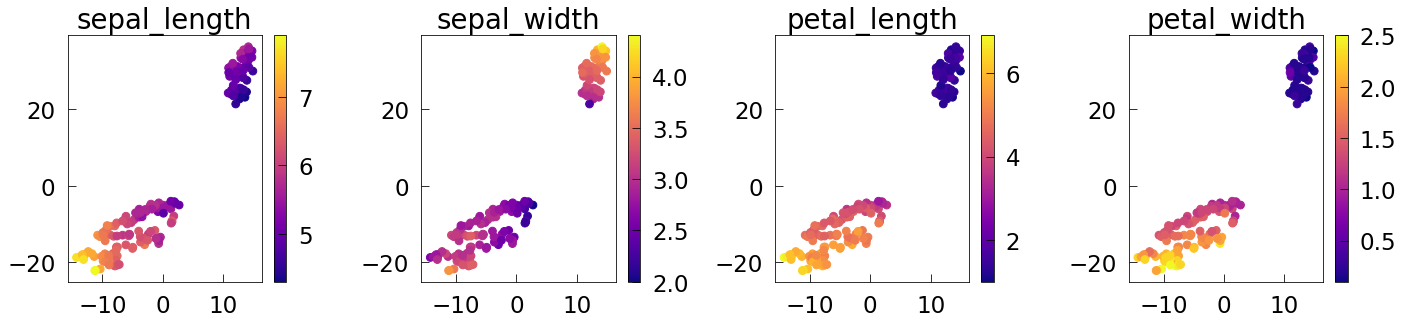

In [113]:
# Just as we did with features representation in the PCA space we can try to understand the new axis of 
# the T-SNE embedding in terms of our features. Here is a bit of code to visualize that

tsne=TSNE(n_components=2,perplexity=20).fit(scaled_data)

X_embedded = tsne.embedding_
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color_list, s=60,cmap='plasma')
plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,20),fontsize=12)
plt.show()
plt.subplots(figsize=(20,5))
for i in range(len(list(df.columns)[:-1])):
    plt.subplot(1,4,i+1)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df[list(df.columns)[:-1][i]], s=60,cmap='plasma')
    plt.title(list(df.columns)[:-1][i])
    plt.colorbar()
plt.tight_layout()
plt.show()

Making a direct correspondance between the new and the former basis is not straight forward here (maybe even impossible : don't quote me on that). Yet to have a feeling about what those axis represent you could check how your different features behave according to those axis.

# Clustering <a class="anchor" id="fifth-bullet"></a>

It could be interesting to check if your data or your dimensionally reduced data present some structure. Indeed if there are some cluster-like structures in your data and if it corresponds to one of your hypothesis then you already came a long way.

But be aware that those are not magical technics : you will need to put some hyperparameters for the model to work, and that is where your expertise and understanding of the data is important.

## K-means clustering <a class="anchor" id="Kmeans-bullet"></a>

K-means clustering is a technique based on calculation of **distances to centroid**. The algorithm calculate a mean, create a set of points around those means, and modify the composition of those clusters so that the variance within all sets is minimized : the points within a cluster should be in this cluster because they are closest to its centroid. 

#### For a little bit of mathematics:

Basically K means aims at finding the right partition of the data ($\pmb{X_1},...,\pmb{X_n}$) into an optimal number of sets $\pmb{S}={S_1,...,S_k}$ so that the within set sum of square is minimized:


$\pmb{\hat{S}}=argmin_{S} \sum_{i}^{k}\sum_{\pmb{X} \in S_i}||\pmb{X}-\pmb{\mu_i}||^2$

where $\mu_i$ is the average within $S_i$



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 2 1 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2
 2 1 1 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 1 1 1 1
 1 1 2 2 1 1 1 1 2 1 2 1 2 1 1 2 1 1 1 1 1 1 2 2 1 1 1 2 1 1 1 2 1 1 1 2 1
 1 2]


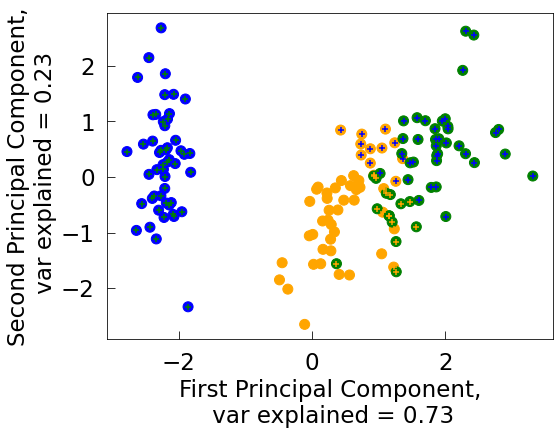

In [35]:
#Let's do a K-means clustering in our new 2D projected PCA space

from sklearn import cluster

K_means = cluster.KMeans(3)#create a K means clustering object that will have 3 clusters
K_means.fit(x_pca[:,:2])#fit
print(K_means.labels_)# just display the cluster id found for each points
color_dict_c={1:'blue', 2:'orange', 0: 'green'}
color_list_c=[color_dict_c[v] for v in K_means.labels_]

var_explained=pca.explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma',s=100)
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list_c,cmap='plasma',marker='+')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))
plt.show()

In circle are the true classes. The `+` is the class found with K-means clustering on the 2D PCA transformed data.
Whenever you are able to see the `+` it means that the class found by the K-means is different from the original class. That's expected! You didn't put any information about original classes. It is already awesome to see some great overlap between the two! It means that this 2D space is probably a good approximation to work with next in your ML analysis.

## Hierarchical clustering <a class="anchor" id="HC-bullet"></a>

It is just an algorithm that hierarchicaly merge two clusters together. You start with two points merged together : the first cluster is made of two points that are the closest to each other according to the norm you chose. Then you **merge clusters that are the closest to each other**. You need to choose what it means for two clusters to be the closest : *i.e.* how do you calculate the meaningfull distance between two clusters? 

You could imagine that this distance should be the distance to their respective centroids, but it could also be the min or max distance between two points from those two different clusters etc... This is called the **choice of linkage**. 

Either you decide what should be the maximum distance threshold and end up with some number of clusters, or you set the number of clusters and you get a threshold distance for defining a cluster. 

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 1 1 2 1 1 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1 2 1 2 2
 1 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 1 2 2 2 1 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


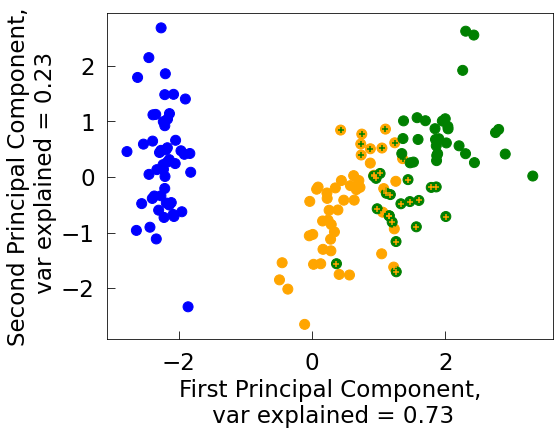

In [36]:
#Same as for Kmeans clustering but this time with Hierachical clustering
ward = cluster.AgglomerativeClustering(
        n_clusters=3, linkage='ward')
ward.fit(x_pca[:,:2])

print(ward.labels_)
color_dict_c={0:'blue', 1:'orange', 2: 'green'}
color_list_c=[color_dict_c[v] for v in ward.labels_]

var_explained=pca.explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma',s=100)
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list_c,cmap='plasma',marker='+')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))
plt.show()

In [37]:
#Just some code to plot the dendrogram that will be explained below
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

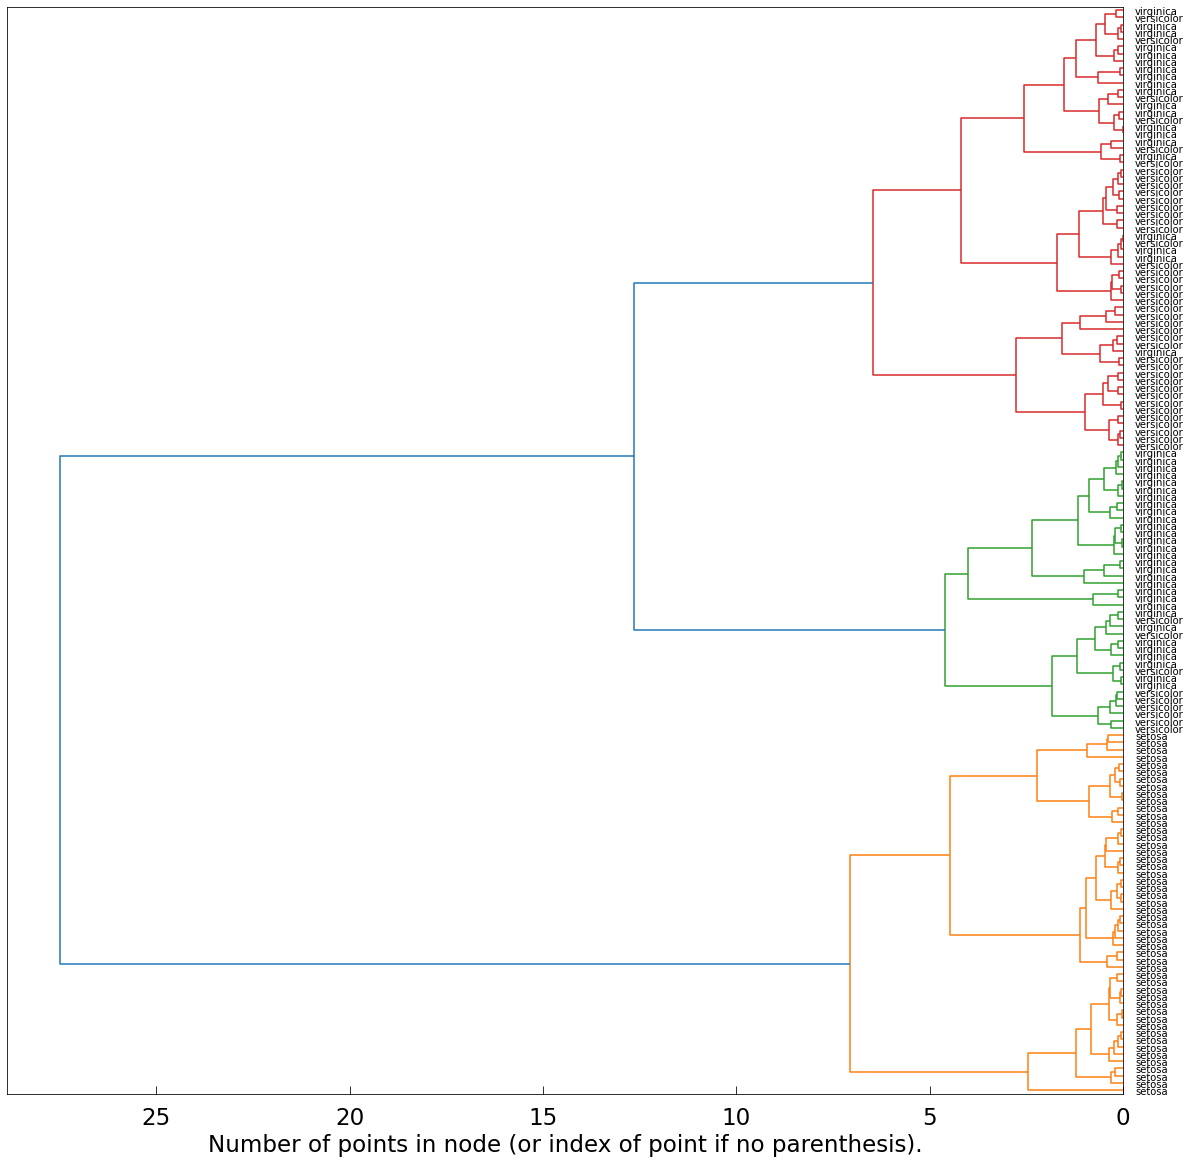

In [38]:
from sklearn import cluster
pylab.rcParams['figure.figsize'] = 20, 20
dendro = cluster.AgglomerativeClustering(
        n_clusters=None,distance_threshold=0, linkage='ward')#here n_cluster = none because I want to explore the link
#between threshold choice and number of clusters
dendro.fit(x_pca[:,:2])
plot_dendrogram(dendro,
                color_threshold=10,
                labels=[df['species'][i]for i in range(len(df['species']))], 
                orientation='left',leaf_font_size=10)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

The dendogram is the representation of the effect of your-cut off to define a cluster. For example if you decide that your threshold is going to be 15 : then you only have two clusters. If you change it to 10 you will have 3 clusters. If you put it to 0 : each point is a cluster!

## DBSCAN <a class="anchor" id="DBSCAN-bullet"></a>

It is a clustering method **based on density**. Basically it starts by defining core points (points that are already densely packed : number of minimum points within a certain distance $\epsilon$ from each other). Then it adds point $j$ to the cluster around those densely packed points under the condition that there is a path of points within a distance $\epsilon$ that connects $j$ to a core point. 

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1  1  1  1  1  1 -1 -1 -1
  1  1 -1  1  1  1  1  1  1  1  1 -1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1]


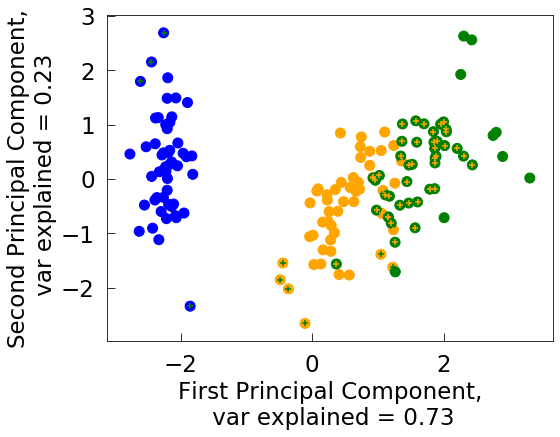

In [92]:
dbscan = cluster.DBSCAN(0.4)# 0.4 this is epsilon. You can also choose what the minimum number of points is.
dbscan.fit(x_pca[:,:2])

print(dbscan.labels_)
color_dict_c={0:'blue', 1:'orange', -1: 'green'}
color_list_c=[color_dict_c[v] for v in dbscan.labels_]
#print(dbscan.distances_)
#print(dist)
var_explained=pca.explained_variance_ratio_
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma',s=100)
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list_c,cmap='plasma',marker='+')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))
plt.show()

# Adjusted Rand Index for clustering performance evaluation <a class="anchor" id="sixth-bullet"></a>

This index only works if you have some labels associated to your points and see how well the structure in your data can recover those labels. 

Very quickly, it compares how similar the calculated and given sets are (how many pairs are part of the same set in both the calculated clusters and the ground truth label clusters, and how many are part of different sets) : true positive and true negative if you will. 
The adjusted rand index takes into account the fact that some clustering could happen by chance and thus remove the estimation of the rand index only due to chance (typically done by estimating clustering from simple permutation model).

The index is comprised between -1 and 1. Negative and close to 0 indexes are indicative of a poor relation between calculated clusters and your hypothesis of what those clusters stand for (the labels). 

In [47]:
from sklearn import metrics

true_label_dict={'setosa':1, 'versicolor':2, 'virginica':3}
true_label=[true_label_dict[df['species'][i]] for i in range(len(df['species']))]

print('Ward Kmean clust ARI',metrics.adjusted_rand_score(true_label, K_means.labels_))
print('Ward agglo clust ARI',metrics.adjusted_rand_score(true_label, ward.labels_))#Just compare original label to found labels
print('Ward dbscan clust ARI',metrics.adjusted_rand_score(true_label, dbscan.labels_))

Ward Kmean clust ARI 0.6201351808870379


ValueError: Found input variables with inconsistent numbers of samples: [150, 569]

# Hyper parameters

# Exo : Breast Cancer dataset <a class="anchor" id="exo-bullet"></a>

Use the breast cancer dataset : `from sklearn.datasets import load_breast_cancer`



Do some data exploration. Check if some features are correlated together. Check whether there is a manifold where you could project the data? The number of dimensions necessary that you would like to keep. What does this projection stand for in term of its axis/or repartition? What do you learn from the data? Finally, do you see clusters? Are those clusters explaining your classes?

In [40]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)
df_cancer.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,malignant
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


#Next cell is correction!So work above!

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#




#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#

#


#

# One possible correction

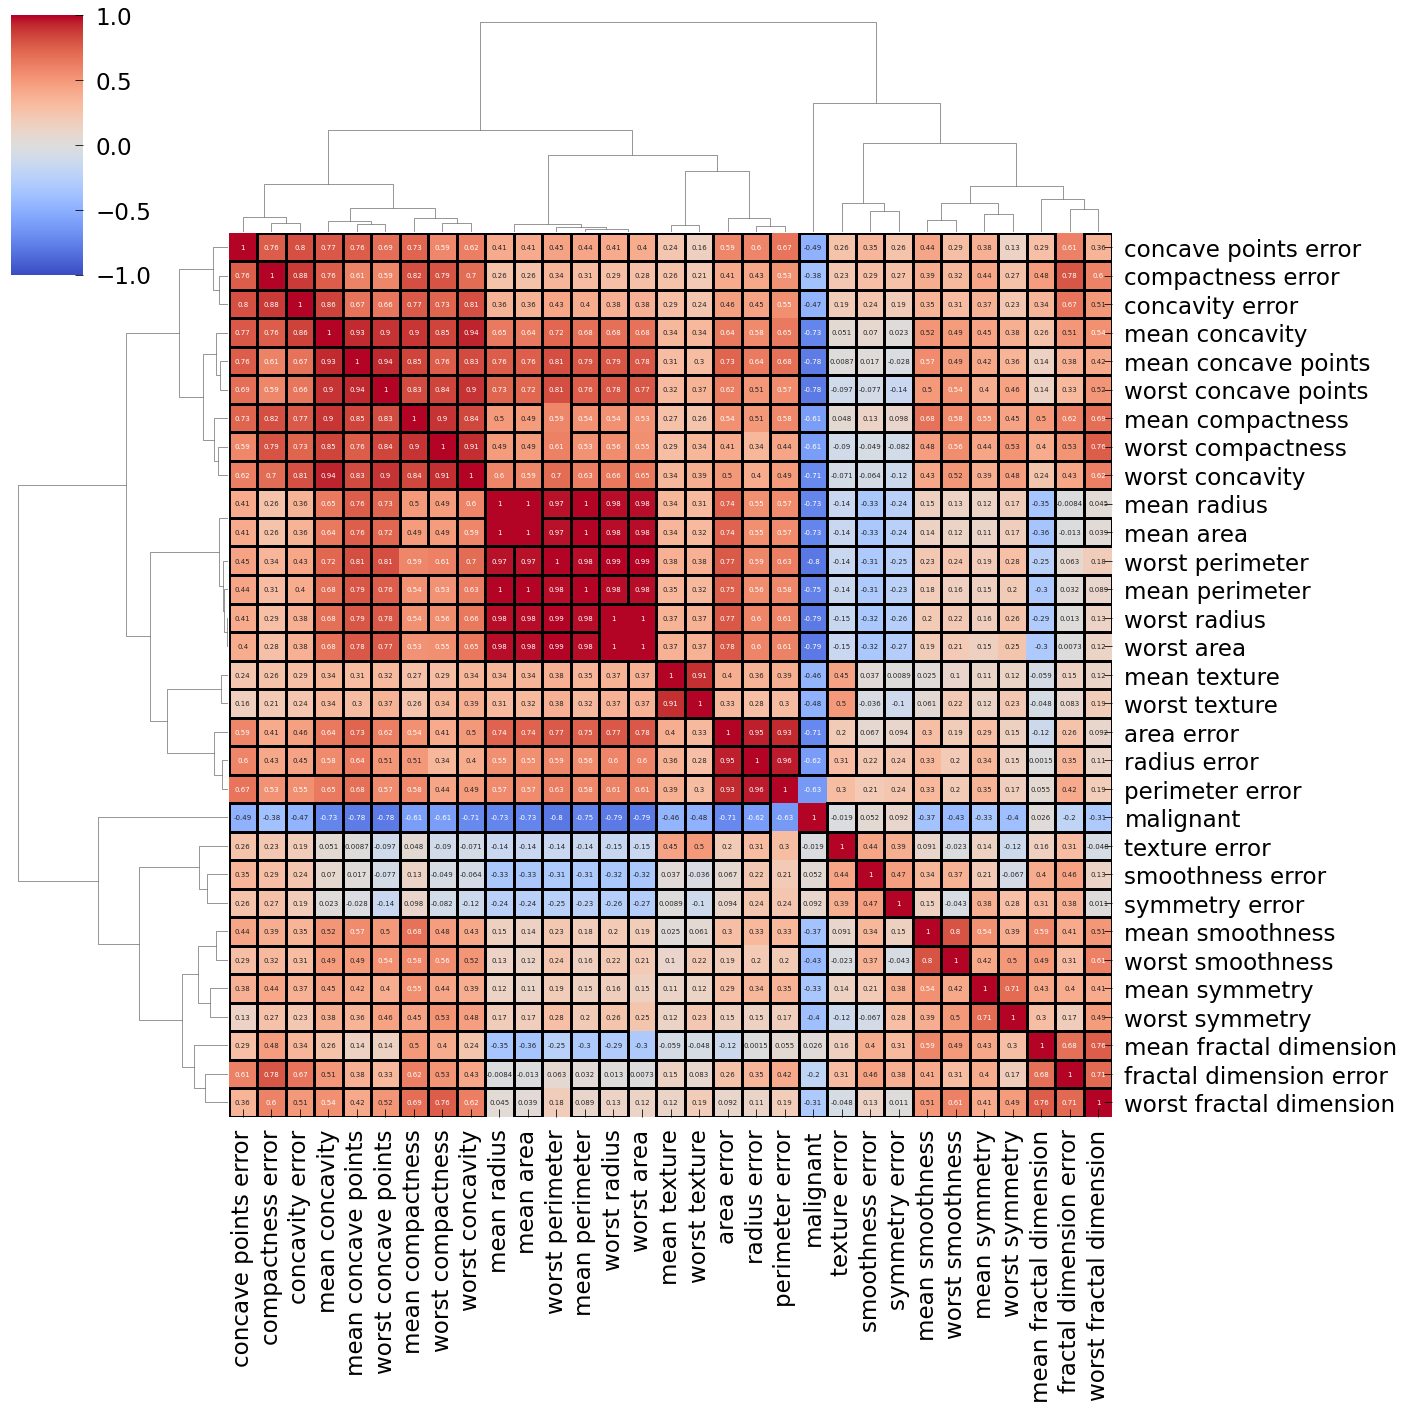

In [61]:
corre=df_cancer.corr(method='spearman')
df_corr = pd.DataFrame(corre,columns=df_cancer.columns)
from scipy.stats import kendalltau, pearsonr, spearmanr

def kendall_pval(x,y):
    return kendalltau(x,y)[1]    
    
def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]
    
def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]

corre_pval=df_cancer.corr(method=spearmanr_pval)
df_corr_pval = pd.DataFrame(corre_pval,columns=df_cancer.columns)

import statsmodels.stats.multitest as ssm
corre_pval_adj=np.array([list(ssm.multipletests([np.array(corre_pval)[i][j]if j!=i else 1 for j in range(np.array(corre_pval).shape[1])]
                                                ,alpha=0.05,method='fdr_bh',is_sorted=False,returnsorted=False)[1]) 
                         for i in range(np.array(corre_pval).shape[0])])
df_corr_pval_adj = pd.DataFrame(corre_pval_adj,columns=df_cancer.columns)

dico_columns={j:i for i,j in enumerate(list(df_corr_pval_adj.columns))}
new_dico_columns={j:i for i,j in enumerate(df_corr_pval_adj.columns)}

dico_swap={dico_columns[s]:new_dico_columns[s] for s in dico_columns.keys()}
dico_swap={new_dico_columns[s]:dico_columns[s] for s in dico_columns.keys()}

the_matrix2=np.array(df_corr_pval_adj)
the_matrix=np.array([[the_matrix2[dico_swap[i],dico_swap[j]] for j in range(len(the_matrix2))]for i in range(len(the_matrix2))])

def highlight_cell(x,y, ax=None, **kwargs):
    rect = plt.Rectangle((x-.5, y-.5), 1,1, fill=False, **kwargs)
    ax = ax or plt.gca()
    ax.add_patch(rect)
    return rect

a=sns.clustermap(df_corr,z_score=None,row_cluster=True,col_cluster=True,method='ward',cmap='coolwarm',
                vmax=1,vmin=-1, annot=True, annot_kws={"size": 7} , figsize=(20,20))

b=a.ax_heatmap
for i in range(len(the_matrix)):
    for j in range(len(the_matrix)):
        if the_matrix[i][j]<0.05:
            highlight_cell(i+0.5,j+0.5,ax=b,color='k',linewidth=3)

In [42]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from operator import itemgetter

skb = SelectKBest(chi2, k=2)#creating the object SelectKBest and settling for 2 best features (k=2) in term of chi2 score
skb.fit(df_cancer[list(df_cancer.columns)[:-1]], df_cancer[list(df_cancer.columns)[-1]])#calculating the chi2 for each features

dico_pval={df_cancer.columns[i]:v for i,v in enumerate(skb.pvalues_)}
print(sorted([[s,dico_pval[s]] for s in dico_pval.keys()],key=itemgetter(1)))#all the features and the chi2 score pvalues associated. use .pvalues_

X_new=skb.transform(df_cancer[list(df_cancer.columns)[:-1]])# keep only the k=2 best features according to the score


[['mean perimeter', 0.0], ['mean area', 0.0], ['area error', 0.0], ['worst perimeter', 0.0], ['worst area', 0.0], ['worst radius', 6.113247507350861e-109], ['mean radius', 8.013976278329821e-60], ['perimeter error', 1.9487748916821141e-56], ['worst texture', 7.896682986749611e-40], ['mean texture', 3.3229219424702834e-22], ['worst concavity', 3.252300636142337e-10], ['radius error', 3.895534287116991e-09], ['mean concavity', 9.001757118104609e-06], ['worst compactness', 1.1083676221330109e-05], ['worst concave points', 0.00024042438366697147], ['mean concave points', 0.0011656363837254035], ['mean compactness', 0.020101299869930245], ['worst symmetry', 0.254421307098499], ['concavity error', 0.3067268121487048], ['compactness error', 0.43336611540692427], ['worst smoothness', 0.5284528674102649], ['concave points error', 0.580621137019778], ['mean symmetry', 0.6119260262217897], ['worst fractal dimension', 0.6303972770282338], ['mean smoothness', 0.6986316439643419], ['texture error', 

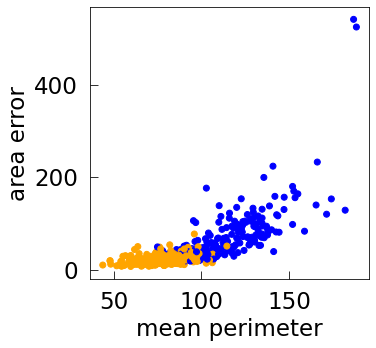

In [64]:
keep_=['mean perimeter','area error']

color_dict={0:'blue', 1:'orange'}
color_list=[color_dict[df_cancer['malignant'][i]] for i in range(len(df_cancer['malignant']))]


plt.figure(figsize=(5,5))
plt.scatter(df_cancer[keep_[0]],df_cancer[keep_[1]],c=color_list,cmap='plasma')
plt.xlabel(keep_[0])
plt.ylabel(keep_[1])

plt.show()

In [65]:
true_label=df_cancer['malignant']
ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='ward')

ward.fit(df_cancer[keep_])
print('Ward agglo clust ARI',metrics.adjusted_rand_score(true_label, ward.labels_))

Ward agglo clust ARI 0.6132735295445475


[4.42720256e-01 1.89711820e-01 9.39316326e-02 6.60213492e-02
 5.49576849e-02 4.02452204e-02 2.25073371e-02 1.58872380e-02
 1.38964937e-02 1.16897819e-02 9.79718988e-03 8.70537901e-03
 8.04524987e-03 5.23365745e-03 3.13783217e-03 2.66209337e-03
 1.97996793e-03 1.75395945e-03 1.64925306e-03 1.03864675e-03
 9.99096464e-04 9.14646751e-04 8.11361259e-04 6.01833567e-04
 5.16042379e-04 2.72587995e-04 2.30015463e-04 5.29779290e-05
 2.49601032e-05 4.43482743e-06]


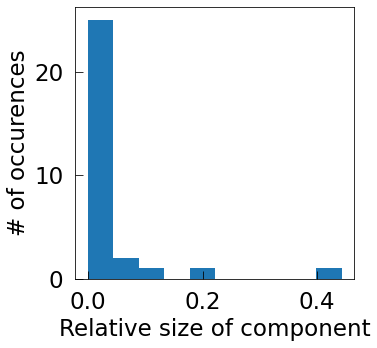

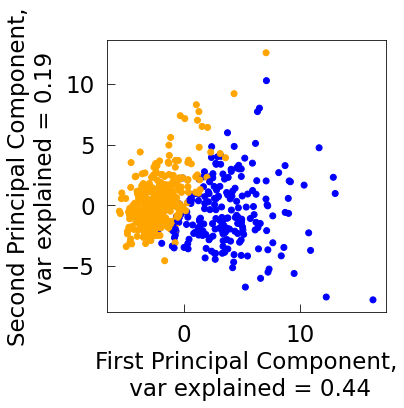

In [43]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #define the object
scaler.fit(df_cancer[list(df_cancer.columns)[:-1]]) # get the mean and sd form our data : in our dataframe features goes up to the last 
#columns. The last columns being the target . So we take all the columns except the last one

scaled_data = scaler.transform(df_cancer[list(df_cancer.columns)[:-1]])# actually transform the data by rencentering and recalling it.

from sklearn.decomposition import PCA

pca = PCA()# create a PCA object

pca.fit(scaled_data)#calculate the eigenvalues and eigenvectors according to rescaled data

x_pca = pca.transform(scaled_data)# Calculate the new points coordinate according to the previously found eigenvectors.

color_dict={0:'blue', 1:'orange'}
color_list=[color_dict[df_cancer['malignant'][i]] for i in range(len(df_cancer['malignant']))]

var_explained=pca.explained_variance_ratio_#get the explained variance ratio from our fitted pca object
print(var_explained)

plt.figure(figsize=(5,5))
plt.hist(var_explained,10)
plt.ylabel('# of occurences')
plt.xlabel('Relative size of component')
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma')
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))

plt.show()

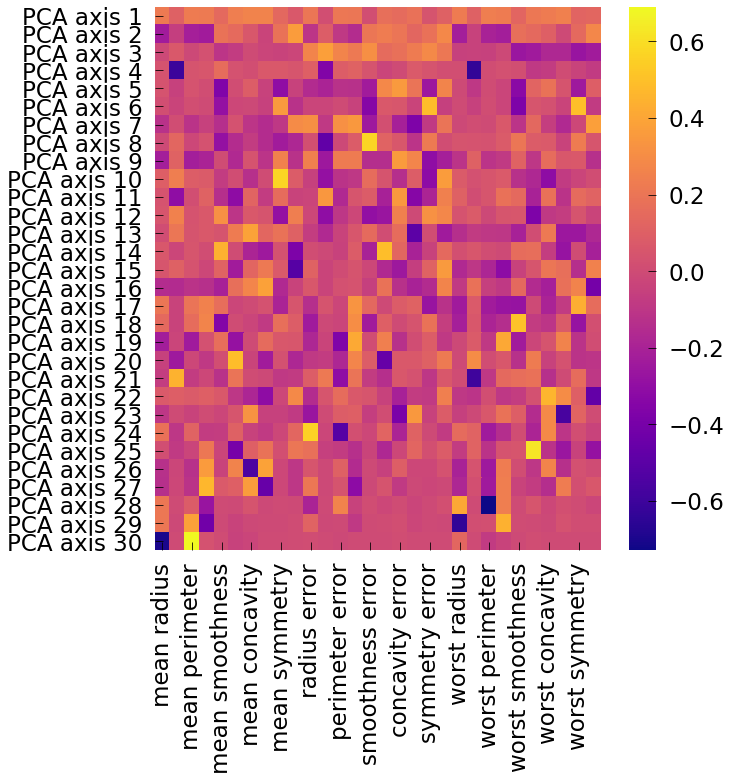

In [44]:
df_comp_cancer = pd.DataFrame(pca.components_,columns=list(df_cancer.columns)[:-1])
plt.figure(figsize=(10,10))
sns.heatmap(df_comp_cancer,cmap='plasma')
plt.yticks(np.arange(0+0.5,len(df_comp_cancer)+0.5,1),['PCA axis '+str(i+1) for i in range(len(df_comp_cancer))],rotation=0)
plt.show()



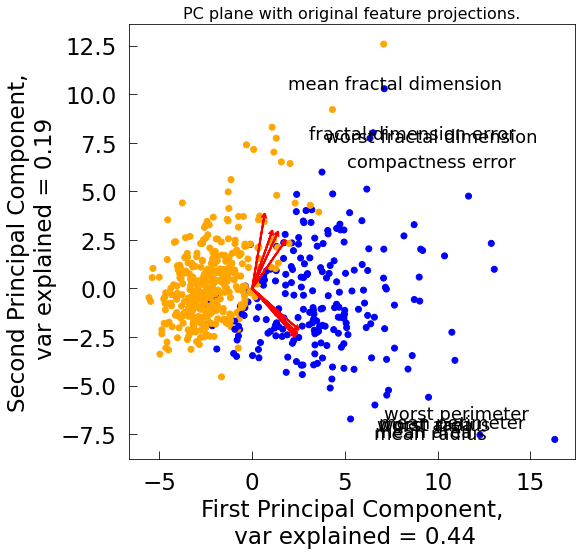


['mean fractal dimension', 'mean radius', 'mean area', 'worst radius', 'worst area', 'mean perimeter', 'worst perimeter', 'worst fractal dimension', 'fractal dimension error', 'compactness error']


In [45]:
from operator import itemgetter
fig, ax = plt.subplots(figsize = (8,8))
 
ax.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma')
    
feature_vectors = pca.components_.T
#Going from the feature base to the PCA base is easy : one is just the other transposed.
important_feature=sorted([[i,(feature_vectors[i][0])**2+abs(feature_vectors[i][1])**2] for i in range(len(feature_vectors))],\
                        key=itemgetter(1),reverse=True)


# we use scaling factors to make the arrows easier to see
arrow_size, text_pos = 10.0,30.0,

# projections of the original features
for v in important_feature[:10]:
    ax.arrow(0, 0, arrow_size*feature_vectors[v[0]][0], arrow_size*feature_vectors[v[0]][1],head_width=0.2, head_length=0.2, linewidth=2, color='red')
    ax.text(feature_vectors[v[0]][0]*text_pos, feature_vectors[v[0]][1]*text_pos, df_cancer.columns[v[0]], color='black',ha='left', va='top', fontsize=18)

    
ax.set_title("PC plane with original feature projections.", fontsize=16)
    
plt.xlabel('First Principal Component,\n var explained = {0:.2f}'.format(var_explained[0]))
plt.ylabel('Second Principal Component,\n var explained = {0:.2f}'.format(var_explained[1]))
plt.show()
print()
print([df_cancer.columns[v[0]] for v in important_feature[:10]])

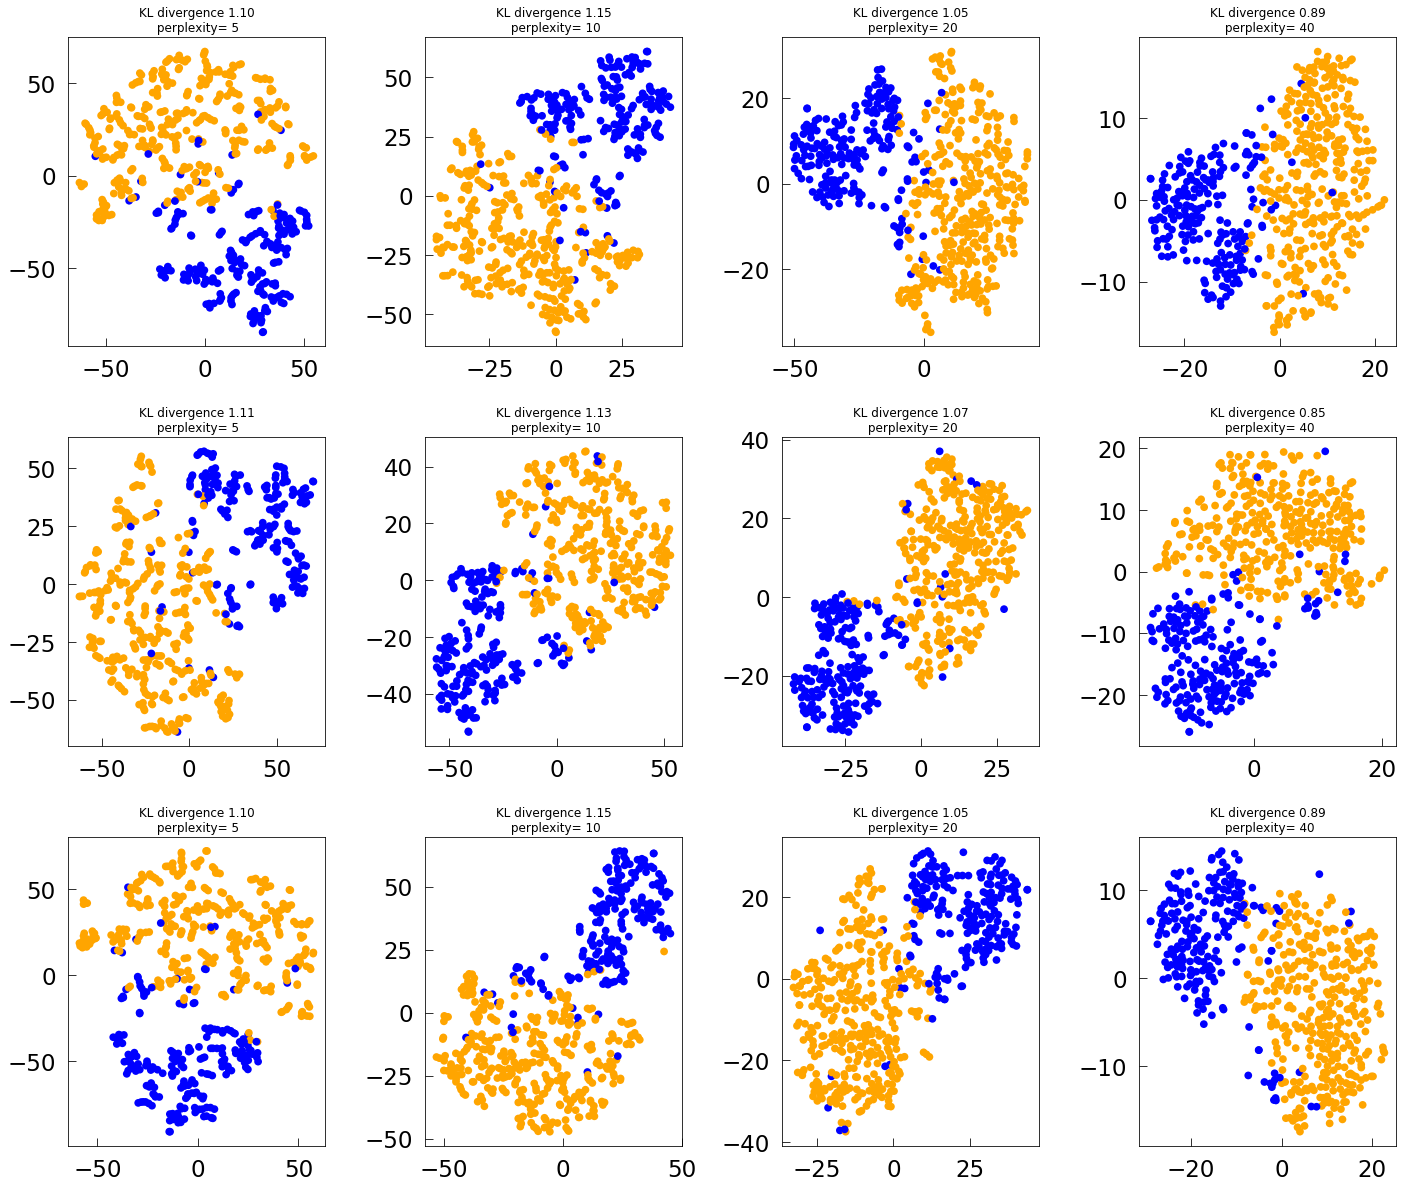

In [26]:
from sklearn.manifold import TSNE
p=[5,10,20,40]
plt.subplots(figsize=(20,17))
for i in range(3):
    for j in range(len(p)):
        plt.subplot(3,4,4*i+j+1)
        tsne=TSNE(n_components=2,perplexity=p[j]).fit(scaled_data)

        X_embedded = tsne.embedding_
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color_list, s=60, lw=0)
        plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,p[j]),fontsize=12)
plt.tight_layout()
plt.show()

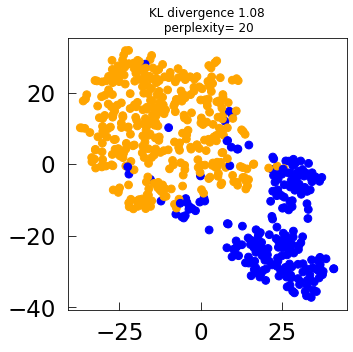

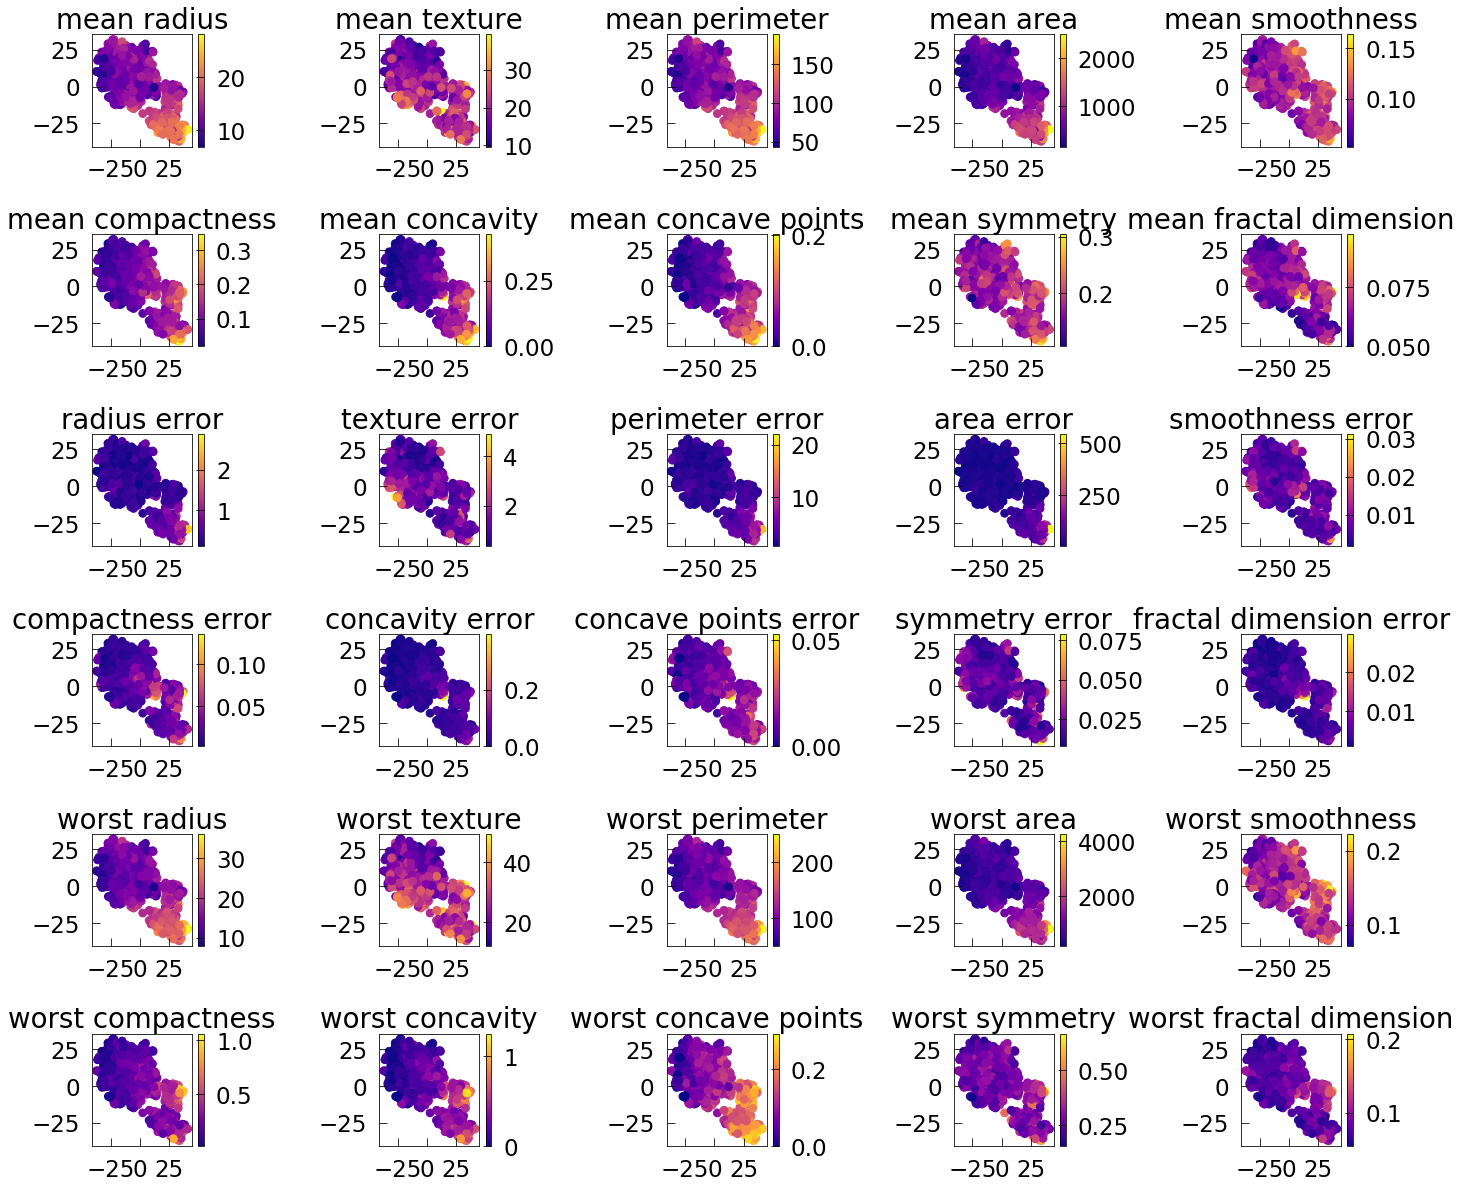

In [33]:
tsne=TSNE(n_components=2,perplexity=20).fit(scaled_data)

X_embedded = tsne.embedding_
plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], color=color_list, s=60,cmap='plasma')
plt.title('KL divergence {0:.2f}\n perplexity= {1}'.format(tsne.kl_divergence_,20),fontsize=12)
plt.show()
plt.subplots(figsize=(20,17))
for i in range(len(cancer['feature_names'])):
    plt.subplot(6,5,i+1)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_cancer[cancer['feature_names'][i]], s=60,cmap='plasma')
    plt.title(cancer['feature_names'][i])
    plt.colorbar()
plt.tight_layout()
plt.show()

# Not right to do even if it gives you nice results

Since distances are not conserved in tSNE doing any kind of distance based clustering is not meaningfull. 

[1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0
 0 1 0 1 1 0 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 0 0
 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 1 1 1
 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1
 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0
 1 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 1 0 0 1 

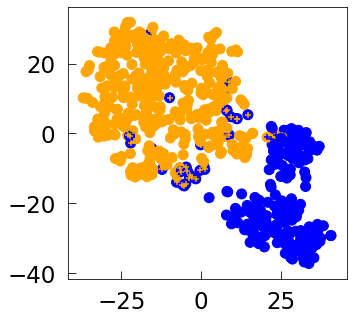

In [34]:
from sklearn import cluster

ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='ward')

ward.fit(X_embedded[:,:2])

print(ward.labels_)
color_dict_c={1:'blue', 0:'orange'}
color_list_c=[color_dict_c[v] for v in ward.labels_]

plt.figure(figsize=(5,5))
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=color_list,cmap='plasma',s=100)
plt.scatter(X_embedded[:,0],X_embedded[:,1],c=color_list_c,cmap='plasma',marker='+')

plt.show()

In [35]:
from sklearn import metrics

true_label=df_cancer['malignant']

print('Ward agglo clust ARI',metrics.adjusted_rand_score(true_label, ward.labels_))


Ward agglo clust ARI 0.7731006996990587


# The PCA clustering results are not great

[0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 1
 1 0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1
 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1
 1 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1
 1 1 1 1 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0
 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 0 1 1
 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 0 1 1 1 1 0 

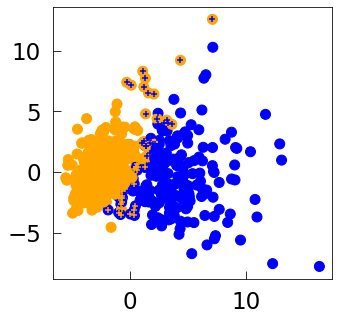

In [51]:
ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='ward')

ward.fit(x_pca[:,:2])

print(ward.labels_)
color_dict_c={0:'blue', 1:'orange'}
color_list_c=[color_dict_c[v] for v in ward.labels_]

plt.figure(figsize=(5,5))
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list,cmap='plasma',s=100)
plt.scatter(x_pca[:,0],x_pca[:,1],c=color_list_c,cmap='plasma',marker='+')

plt.show()

In [52]:
true_label=df_cancer['malignant']

print('Ward agglo clust ARI',metrics.adjusted_rand_score(true_label, ward.labels_))

Ward agglo clust ARI 0.6594271719206948


### Full PCA

In [53]:
ward = cluster.AgglomerativeClustering(
        n_clusters=2, linkage='ward')

ward.fit(x_pca)
print('Ward agglo clust ARI',metrics.adjusted_rand_score(true_label, ward.labels_))

Ward agglo clust ARI 0.5750409366326297
